In [ ]:
!pip install tensorflow transformers datasets scikit-learn joblib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 15.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2024.12.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which i

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import RobertaTokenizer, TFRobertaForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import joblib
from sklearn.metrics import classification_report

In [ ]:
from google.colab import files


uploaded = files.upload()

Saving hate_speech_dataset.csv to hate_speech_dataset.csv


In [ ]:
df = pd.read_csv('hate_speech_dataset.csv')


df.head()

,si,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [ ]:
from sklearn.preprocessing import LabelEncoder


label_encoder = LabelEncoder()

df.loc[:, 'class'] = label_encoder.fit_transform(df['class'])




def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text


df.loc[:, 'tweet'] = df['tweet'].apply(clean_text)
df.head()

,si,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,rt mayasolovely as a woman you shouldnt compla...
1,1,3,0,3,0,1,rt mleew boy dats coldtyga dwn bad for cuffin ...
2,2,3,0,3,0,1,rt urkindofbrand dawg rt sbabylife you ever fu...
3,3,3,0,2,1,1,rt cganderson vivabased she look like a tranny
4,4,6,0,6,0,1,rt shenikaroberts the shit you hear about me m...


In [ ]:

X_train, X_test, y_train, y_test = train_test_split(df['tweet'], df['class'], test_size=0.2, random_state=42)

print(f"Training Samples: {len(X_train)}")
print(f"Testing Samples: {len(X_test)}")


Training Samples: 19826
Testing Samples: 4957


In [ ]:

max_words = 10000
max_len = 100


tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)


X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)


joblib.dump(tokenizer, 'tokenizer.pkl')

print("Tokenizer & Padding Done!")


Tokenizer & Padding Done!


In [ ]:

lstm_model = Sequential([
    Embedding(input_dim=max_words, output_dim=128, input_length=max_len),
    LSTM(64, return_sequences=True),
    Dropout(0.5),
    LSTM(32),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

lstm_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


history = lstm_model.fit(X_train_pad, y_train, validation_data=(X_test_pad, y_test), epochs=10, batch_size=32)



lstm_model.save('lstm_hate_speech_model.h5')

print("LSTM Model Trained & Saved!")


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


620/620 ━━━━━━━━━━━━━━━━━━━━ 88s 134ms/step - accuracy: 0.7973 - loss: 0.6081 - val_accuracy: 0.8868 - val_loss: 0.3248
Epoch 2/10
620/620 ━━━━━━━━━━━━━━━━━━━━ 143s 137ms/step - accuracy: 0.9125 - loss: 0.2649 - val_accuracy: 0.8947 - val_loss: 0.2971
Epoch 3/10
620/620 ━━━━━━━━━━━━━━━━━━━━ 80s 129ms/step - accuracy: 0.9380 - loss: 0.1731 - val_accuracy: 0.8878 - val_loss: 0.3223
Epoch 4/10
620/620 ━━━━━━━━━━━━━━━━━━━━ 88s 138ms/step - accuracy: 0.9596 - loss: 0.1246 - val_accuracy: 0.8812 - val_loss: 0.4476
Epoch 5/10
620/620 ━━━━━━━━━━━━━━━━━━━━ 137s 131ms/step - accuracy: 0.9707 - loss: 0.0877 - val_accuracy: 0.8771 - val_loss: 0.4790
Epoch 6/10
620/620 ━━━━━━━━━━━━━━━━━━━━ 89s 143ms/step - accuracy: 0.9754 - loss: 0.0717 - val_accuracy: 0.8860 - val_loss: 0.4919
Epoch 7/10
620/620 ━━━━━━━━━━━━━━━━━━━━ 138s 136ms/step - accuracy: 0.9813 - loss: 0.0543 - val_accuracy: 0.8753 - val_loss: 0.5585
Epoch 8/10
620/620 ━━━━━━━━━━━━━━━━━━━━ 139s 131ms/step - accuracy: 0.9841 - loss: 0.0470 -

LSTM Model Trained & Saved!


In [ ]:
from google.colab import files


files.download('lstm_hate_speech_model.h5')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:

y_pred = lstm_model.predict(X_test_pad)

y_pred_classes = y_pred.argmax(axis=1)


print(classification_report(y_test, y_pred_classes))


155/155 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step
              precision    recall  f1-score   support

           0       0.34      0.21      0.26       290
           1       0.91      0.94      0.93      3832
           2       0.81      0.79      0.80       835

    accuracy                           0.87      4957
   macro avg       0.69      0.65      0.66      4957
weighted avg       0.86      0.87      0.87      4957



In [ ]:

class_mapping = {
    0: "Hate Speech",
    1: "Offensive Language",
    2: "Neither"
}


def predict_hate_speech(text):
    cleaned_text = clean_text(text)
    text_seq = tokenizer.texts_to_sequences([cleaned_text])
    text_pad = pad_sequences(text_seq, maxlen=max_len)

    prediction = lstm_model.predict(text_pad)
    predicted_class = prediction.argmax(axis=1)[0]

    class_label = class_mapping[predicted_class]
    return predicted_class, class_label


sample_text = "I hate everyone!"
num_class, label_class = predict_hate_speech(sample_text)
print(f"Predicted Class: {num_class} - {label_class}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Predicted Class: 0 - Hate Speech


In [ ]:

test_sentences = [
    "I hate you and your entire community!",
    "You're so stupid and annoying!",
    "I think we should discuss this calmly.",
    "You are a worthless piece of trash!",
    "What a terrible day, everything is awful!",
    "Hey, how are you doing today?",
    "This is absolutely ridiculous and pathetic!",
    "I love my friends and family!",
    "Go to hell, nobody wants you here!",
    "You are so dumb, I can't believe you exist.",
    "Let's work together and make things better!",
    "You should die, nobody cares about you!",
]

for sample_text in test_sentences:
    num_class, class_label = predict_hate_speech(sample_text)
    print(f"Sentence: {sample_text}")
    print(f"Predicted Class: {class_label} ({num_class})")



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Sentence: I hate you and your entire community!
Predicted Class: Neither (2)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
Sentence: You're so stupid and annoying!
Predicted Class: Offensive Language (1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
Sentence: I think we should discuss this calmly.
Predicted Class: Neither (2)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
Sentence: You are a worthless piece of trash!
Predicted Class: Offensive Language (1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
Sentence: What a terrible day, everything is awful!
Predicted Class: Neither (2)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
Sentence: Hey, how are you doing today?
Predicted Class: Offensive Language (1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
Sentence: This is absolutely ridiculous and pathetic!
Predicted Class: Offensive Language (1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
Sentence: I love my friends and family!
Predicted Class: Neither (2)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Sentence: Go

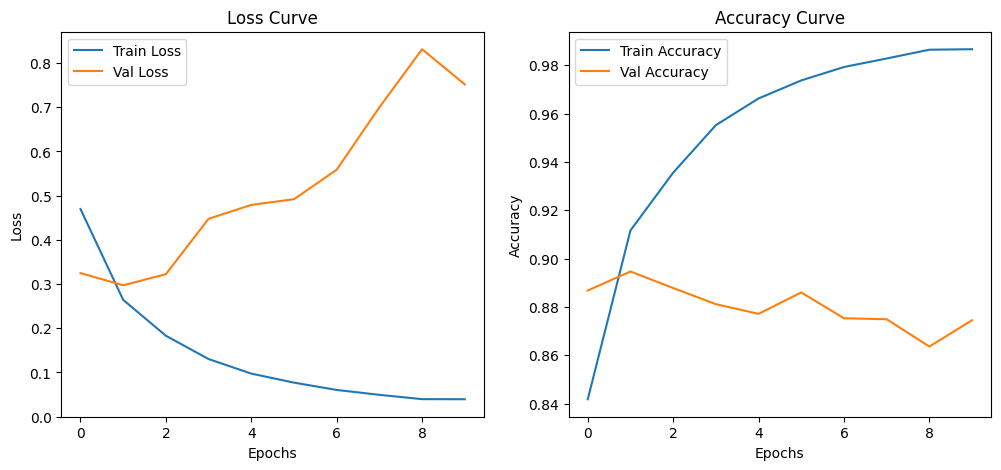

In [ ]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Curve')
    plt.legend()

    plt.show()

plot_training_history(history)


155/155 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step


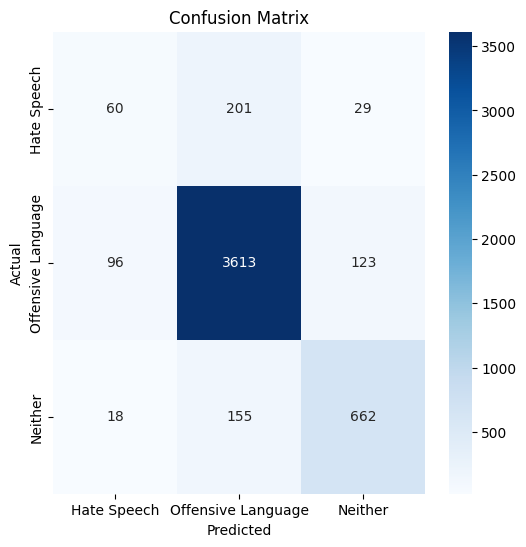

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

def plot_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

y_pred_classes = lstm_model.predict(X_test_pad).argmax(axis=1)

plot_confusion_matrix(y_test, y_pred_classes, labels=['Hate Speech', 'Offensive Language', 'Neither'])


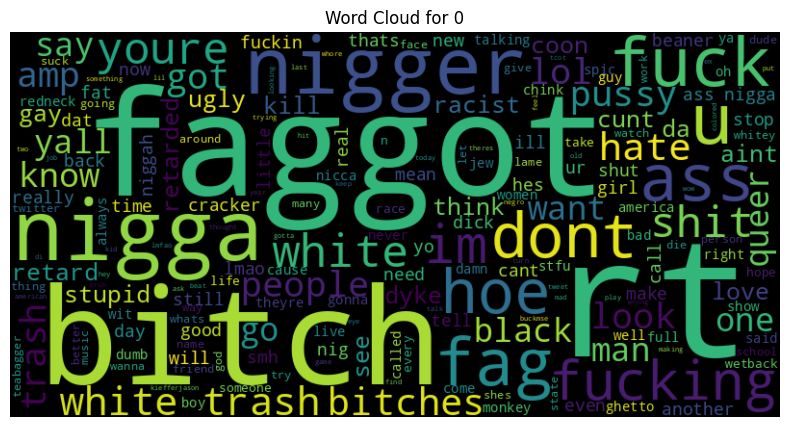

In [ ]:
from wordcloud import WordCloud

def generate_wordcloud(df, class_label):
    text = ' '.join(df[df['class'] == class_label]['tweet'])
    wordcloud = WordCloud(width=800, height=400, background_color='black').generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for {class_label}')
    plt.show()


generate_wordcloud(df, class_label=0)


155/155 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step


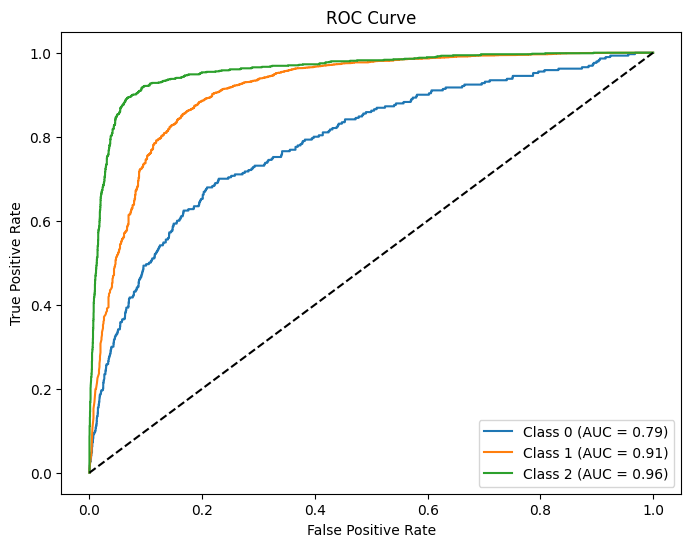

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

def plot_roc_curve(y_true, y_pred_proba, num_classes):
    y_true_bin = label_binarize(y_true, classes=[0, 1, 2])

    plt.figure(figsize=(8, 6))
    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_proba[:, i])
        auc_score = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Class {i} (AUC = {auc_score:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()

y_pred_proba = lstm_model.predict(X_test_pad)

plot_roc_curve(y_test, y_pred_proba, num_classes=3)


In [ ]:
from google.colab import files


files.download('tokenizer.pkl')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>